# Ch.4 신경망학습  

> 손실함수를 최소화하는 가중치 매개변수를 찾는 것이 학습목표  
> 손실함수 값을 작게 만드는 기법으로 함수기울기를 활용하는 경사법을 소개

## 목차
```
4.1 데이터에서 학습한다! 
__4.1.1 데이터 주도 학습 
__4.1.2 훈련 데이터와 시험 데이터 
4.2 손실 함수 
__4.2.1 평균 제곱 오차 
__4.2.2 교차 엔트로피 오차 
__4.2.3 미니배치 학습 
__4.2.4 (배치용) 교차 엔트로피 오차 구현하기 
__4.2.5 왜 손실 함수를 설정하는가? 
4.3 수치 미분 
__4.3.1 미분 
__4.3.2 수치 미분의 예 
__4.3.3 편미분 
4.4 기울기 
__4.4.1 경사법(경사 하강법) 
__4.4.2 신경망에서의 기울기 
4.5 학습 알고리즘 구현하기 
__4.5.1 2층 신경망 클래스 구현하기
__4.5.2 미니배치 학습 구현하기 
__4.5.3 시험 데이터로 평가하기
```

## 4.1 데이터에서 학습한다
---
### 4.1.1 데이터 주도 학습

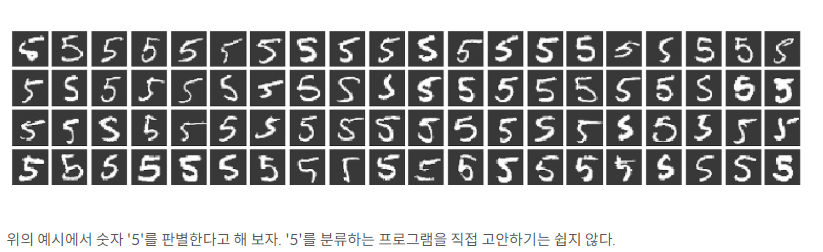  

'5'를 인식하는 방법은 이미지에서 특징을 추출하고 그 특징의 패턴을 기계학습 기술로 학습하는 방법이 있습니다  
1. 이미지 특징은 CV분야의 SIFT, SURF, HOG 등의 특징을 많이 사용하고
1. 변환된 벡터를 가지고 지도학습방식의 대표분류기법인 SVM, KNN 등으로 학습합니다  

* 위의 방식으로 기계학습하는 방식은 아래 그림의 2번쨰와 같습니다.
* 반면 딥러닝(신경망) 방식은 아래 그림의 맨아래와 같습니다
* 딥러닝학습의 장점은 사람이 생각하는 특징에 관계없이 주어진 데이터를 온전히 학습하므로, end-to-end로 학습할 수 있습니다

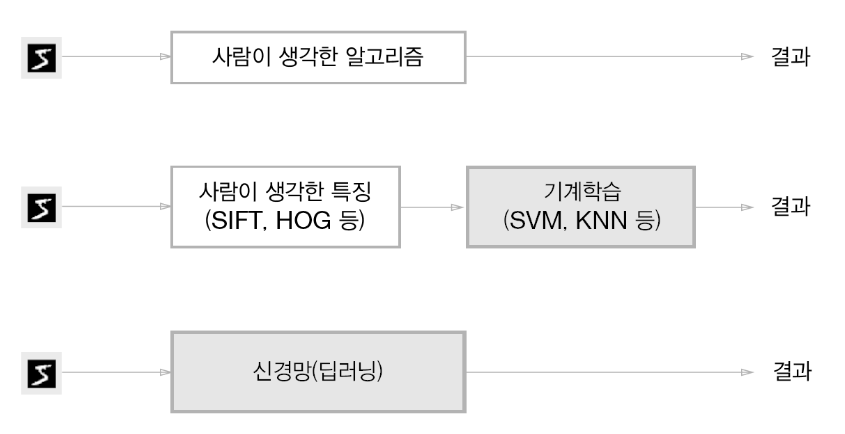

### 4.1.2. 훈련 데이터와 시험 데이터

* 기계학습 문제는 데이터를 훈련데이터와 시험데이터로 나눠 학습/실험을 수행합니다
* 훈련데이터로 만들어진 모델의 범용능력을 제대로 평가하기 위해 훈련/시험 데이터를 분리하는 것입니다
* 범용능력이란 아직 보지못한 데이터에 대해 문제를 올바로 풀어내는 능력을 의미합니다. (기계학습의 최종목표이기도 합니다)
* 참고로 한 데이터 셋에만 지나치게 최적화 된 상태를 __오버피팅__ 이라고 합니다 (오버피팅을 피하는 것 또한 기계학습의 중요과제입니다)


## 4.2 손실함수
---

* 신경망 학습에서 현재 상태를 나타내는 지표로 손실함수를 사용합니다
* 신경망 학습은 이 손실함수를 가장 좋게 만들어주는 가중치 매개변수의 값을 탐색합니다
* 손실함수로는 오차제곱합(SSE)나 교차 엔트로피(Croos Entropy)를 사용합니다
---

### 4.2.1 오차제곱합(Sum of Squares for Error, SSE)

$E = \frac{1}{2} \sum_k (y_k -t_k )^2 $
* $y_k$ : 신경망의 출력
* $t_k$ : 정답레이블 
* k : 데이터 차원의 수

In [21]:
import numpy as np

y = ([0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0])
t = ([0,0,1,0,0,0,0,0,0,0])

print(np.array(y).shape)
print(np.array(t).shape)

def sum_squares_error(y,t) :
    return 0.5 * np.sum((y-t)**2)

sum_squares_error(np.array(y),np.array(t))

(10,)
(10,)


0.09750000000000003

In [22]:
y = [0.1,0.05,0.1,0,0.05,0.1,0,0.6,0,0]
sum_squares_error(np.array(y),np.array(t))

0.5975

### 4.2.2 교차 엔트로피 오차(Cross Entropy Error. CEE)  
$E =  -\sum_k t_k \log y_k$
* $y_k$ : 신경망 출력
* $t_k$ : 정답 레이블

In [23]:
def cross_entropy_error(y,t):
    delta = 1e-7 
    return -np.sum(t*np.log(y+delta))

# log y 에서 y 에 0을 넣으면 log값을 계산할 수 없으므로 값에 영향이 적은 아주 작은 값을 추가

In [24]:
t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1,0.05,0.6,0,0.05,0.1,0,0.1,0,0]

cross_entropy_error(np.array(y),np.array(t))

0.510825457099338

In [25]:
y= [0.1,0.05,0.1,0,0.05,0.1,0,0.6,0,0]

cross_entropy_error(np.array(y),np.array(t))

2.302584092994546

### 4.2.3 미니배치 학습
* 훈련 데이터 전체의 손실함수의 합을 구하는 방법  
$E = -\frac{1}{N} \sum_n \sum_k t_{nk} \log y_{nk}$  
* N : 데이터의 갯수  
* $t_{nk}$ : n번째 데이터의 k번째 값
* $y_{nk}$ : n번째 데이터의 k번째 신경망 출력  
  
신경망 학습할때 훈련데이터에서 일부만 골라 학습을 수행하는데,  
이때 일부를 __미니배치__ 라고 하고 이런 학습법을 __미니배치 학습법__ 이라고 합니다

In [26]:
import sys, os
from dataset.mnist import load_mnist

In [27]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist



(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize = True, one_hot_label=True)

print(x_train.shape) 
print(t_train.shape)

(60000, 784)
(60000, 10)


In [28]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [29]:
np.random.choice(60000, 10)

array([ 6309, 36905, 23709, 43150, 23372, 20343, 28381, 25272,  2421,
       55101])

In [30]:
def cross_entropy_error(y,t):    #원핫 인코딩의 경우
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y + 1e-7)) / batch_size   



*  원핫인코딩이 아닌경우 
* return  = =np.sum(np.log(y[np.arange(batch_size),t] + 1e-7)) / batch_size
* 즉, t*np.log(y) 부분을 np.log(y[np.arange(batch_size), t] + 1e-7) / batch_size로 구현

### 왜 손실함수를 설정할까?

* 우리의 목표는 높은 정확도를 끌어내는 매개변수 값을 찾는 것
* 손실함수를 가능한 작게하는 매개변수값을 찾기위해 매개변수의 미분으로 경사하강법으로 매개변수값을 갱신하는 과정 반복
* _신경망 학습시 정확도를 지표로 삼으면 안된다. 왜냐하면 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 때문_

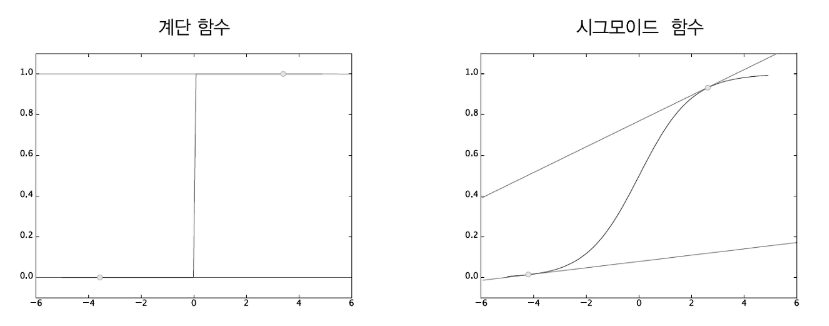

* 정확도를 지표로 삼게 되면 계단함수에 대한 미분값을 적용한 것과 비슷하다
* 정확도는 매개변수의 미소한 변화에 거의 반응이 없고. 반응이 있어도 분연속적으로 갑자기 변화한다

## 4.3 수치미분
### 4.3.1 미분

In [31]:
# 나쁜구현
def numerical_diff(f,x) :
    h = 1e-50
    return (f(x+h)-f(x))/h

np.float32(1e-50)

0.0

해당 구현 방식은 반올림오차의 문제를 발생시킵니다  
해당 문제는 h 값을 $10^{-4}$ 정도로 하면 좋을 결과를 얻는다고 합니다  

오차를 줄이기 위해 중심차분 또는 중앙차분의 방식을 쓰기도 합니다.
* $\frac{f(x+h)-f(x-h)}{2h}$ 의 형식으로 주는 방식
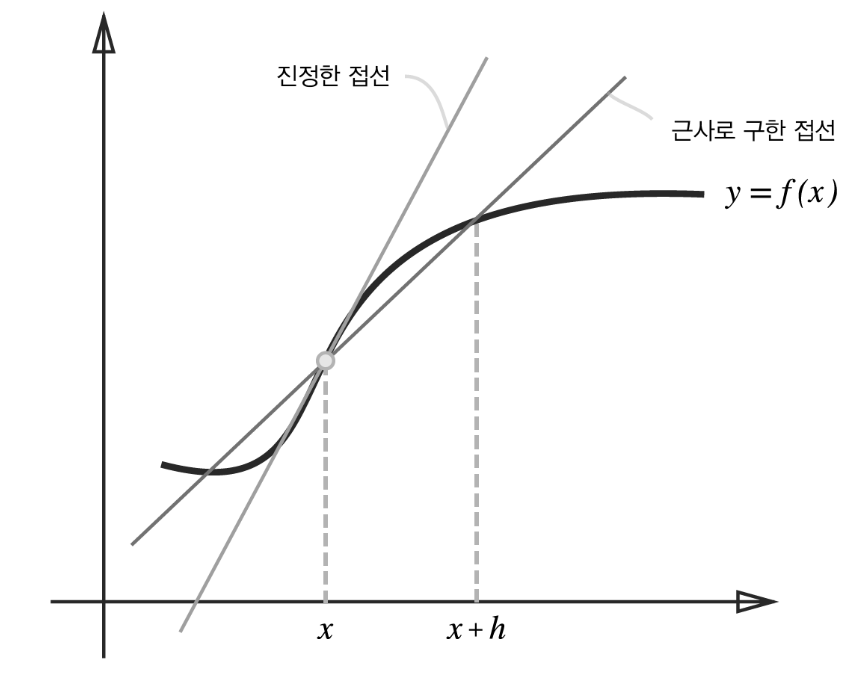

In [32]:
def numerical_diff(f,x) :
    h = 1e-4
    return (f(x+h)-f(x-h))/(2*h)

$y = 0.01x^2 +0.1x$

In [33]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

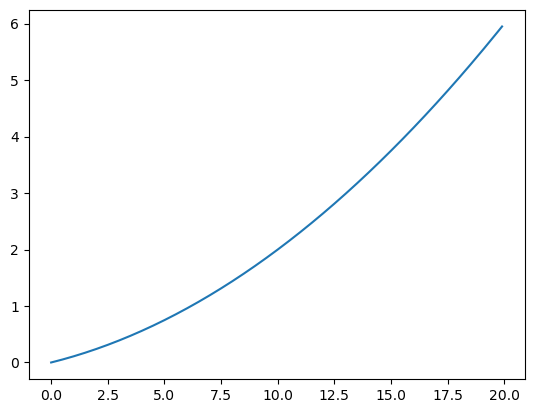

In [34]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,20,0.1)
y = function_1(x)
plt.plot(x,y)
plt.show()

In [35]:
numerical_diff(function_1,5)

0.1999999999990898

In [36]:
numerical_diff(function_1,10)

0.2999999999986347

### 4.3.3 편미분
$f(x_0,x_1)=x_0^2+x_1^2$

In [37]:
def function_2(x):
    return x[0]**2 + x[1]**2

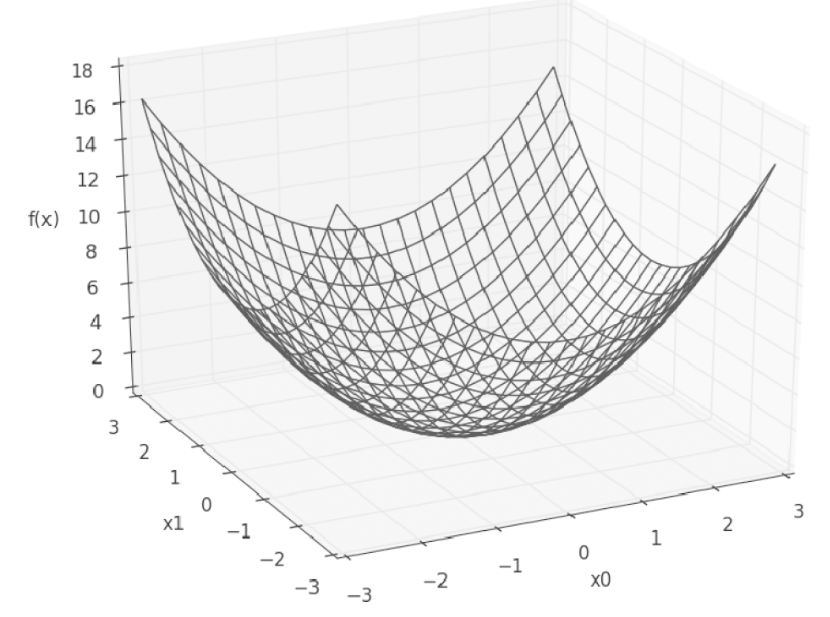

$x_0 = 3, x_1 = 4 에서 \frac{\partial f}{\partial x_0} 를 구하라 $  
$x_1=4$로 상수로 넣고 계산하는 방식으로 구현

In [38]:
def function_tmp1(x0):
    return x0**2 +4**2

numerical_diff(function_tmp1,3)

6.00000000000378

## 4.4 기울기

$x_0 와 x_1$ 의 편미분을 동시에 구하는 방법 구현하는 방법  
각 변수값별로 미소값 h의 변화를 주어 구하는 방식

In [39]:
def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x)   # x와 형상이 같은 배열 생성
    
    for i in range(x.size):
        tmp_val = x[i]
        #f(x+h) 계산
        x[i] = tmp_val + h
        f1 = f(x)
        #f(x-h) 계산
        x[i] = tmp_val - h
        f2 = f(x)
        
        grad[i] = (f1 - f2)/(2*h)
        x[i] = tmp_val # 값 복원
        
    return grad

In [40]:
numerical_gradient(function_2, np.array([3.0,4.0]))   #(3,4)지점의 기울기 값

array([6., 8.])

In [41]:
numerical_gradient(function_2, np.array([3,4]))   # 얘는 왜 이상한 값이 나올까요?

array([25000, 35000])

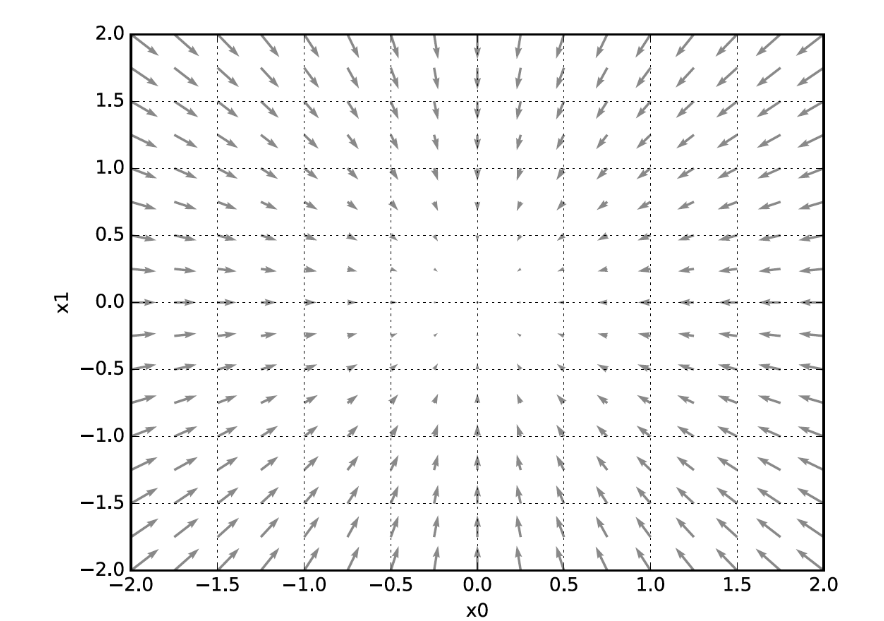

 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 줄이는 방향 (0,0) 지점!

### 4.4.1 경사하강법

* 경사하강법은 현위치에서 기울어진 방향으로 일정거리(학습률)만큼 이동하는 것입니다
* 경사하강법을 통해 함수의 값(loss)를 줄이는 방식으로 기계학습, 신경망학습에 사용합니다
* 만약 함수의 값을 최대화하고자 한다면, 경사상승법을 사용하기도 합니다
* 수식에서 $\eta$는 학습률을 의미합니다
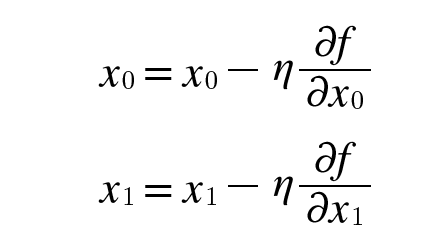

In [42]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

경사하강법으로 $f(x_0,x_1)=x_0^2+x_1^2$ 의 최솟값 구하기

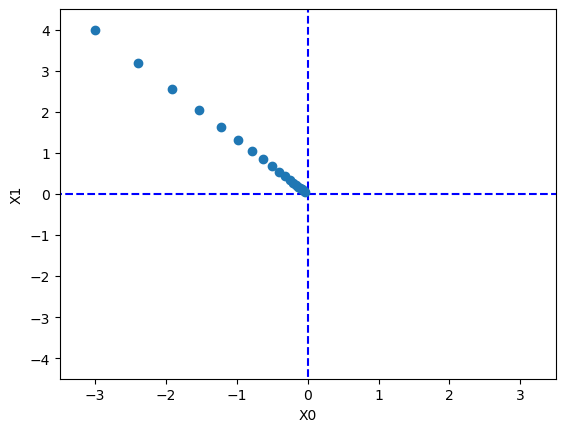

In [43]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    
lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b') # x축
plt.plot( [0,0], [-5, 5], '--b') # y축
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

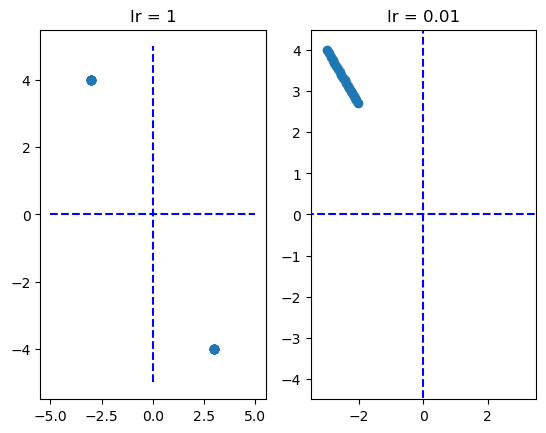

In [44]:
init_x = np.array([-3.0, 4.0])    

step_num = 20
x1, x_history1 = gradient_descent(function_2, init_x, lr=1, step_num=step_num)
init_x = np.array([-3.0, 4.0])    
x2, x_history2 = gradient_descent(function_2, init_x, lr=0.01, step_num=step_num)

plt.subplot(121)
plt.plot(x_history1[:,0], x_history1[:,1], 'o')
plt.plot( [-5, 5], [0,0], '--b') # x축
plt.plot( [0,0], [-5, 5], '--b') # y축
plt.title("lr = 1")

plt.subplot(122)
plt.plot(x_history2[:,0], x_history2[:,1], 'o')
plt.plot( [-5, 5], [0,0], '--b') # x축
plt.plot( [0,0], [-5, 5], '--b') # y축
plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.title("lr = 0.01")
plt.show()

lr이 너무 크면 발산하는 문제가 있고 / 너무 작으면 거의 갱신되지 않은채 끝나버린다.

* 학습률과 같은 매개변수를 하이퍼 파라미터라고 합니다.

### 4.4.2  신경망에서의 기울기

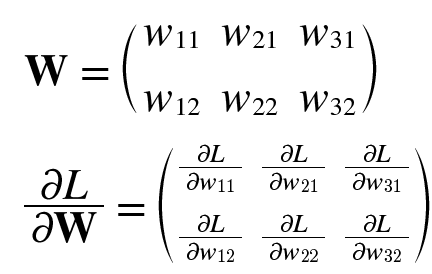

가중치가 $W$ 일때 손실함수가 $L$인 신경망의 가중치 편미분
- 가중치를 변경할때 손실함수가 얼마나 변화하느냐를 보여줍니다

In [45]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient


class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [46]:
net = simpleNet()
print(net.W)  # 가중치 랜덤 추철

[[ 1.09357002 -0.33216008 -0.46900013]
 [-1.31644174 -0.21634733  1.55791884]]


In [47]:
x = np.array([0.6, 0.9])

p = net.predict(x)
print(p)

[-0.52865555 -0.39400864  1.12072688]


In [48]:
np.argmax(p) # 최댓값의 인덱스

2

In [49]:
t = np.array([0, 0, 1])
net.loss(x,t)

0.34503169842777537

In [50]:
f = lambda w: net.loss(x, t) # f(w) : 로스값 출력
dW = numerical_gradient(f, net.W) # f(W)의 각 지점에서의 기울기값 출력

print(dW)

[[ 0.081656    0.0934253  -0.17508129]
 [ 0.12248399  0.14013795 -0.26262194]]


## 4.5 학습 알고리즘 구현

* 1단계 - 미니배치 :

훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표이다.

* 2단계 - 기울기 산출 :

미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.

* 3단계 - 매개변수 갱신 :

가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

* 4단계 - 반복 :

1~3단계를 반복한다.

#### 이때 데이터를 미니배치로 무작위로 추출하므로 확률적 경사하강법(SGD)라 합니다.

### 4.5.1 2층 신경망 클래스 구현

In [51]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01): #각 사이즈별로 랜덤배정
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t): #최대확률 인덱스가 정답 맞춘 비율
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

TwoLayerNet 클래스가 사용하는 변수  
1. params : 신경망의 매개변수를 보관하는 딕셔너리 변수(인스턴스 변수)
1. grads : 기울기를 보관하는 딕셔너리 변수(numerical_gradient() 메서드의 반환 값)

TwoLayerNet 클래스의 메서드  
```__init__(self, input_size, hidden_size, output_size)``` : 초기화를 수행한다. 인수는 순서대로 입력층의 뉴런 수, 은닉층의 뉴런 수, 출력층의 뉴런 수  
```predict(self, x)``` : 예측(추론)을 수행한다. 인수 x는 이미지 데이터  
`loss(self, x, t)` : 손실 함수의 값을 구한다. x는 이미지 데이터, t는 정답 레이블  
`accruacy(self, x, t)` : 정확도를 구한다.  
`numerical_gradient(self, x, t)` : 가중치 매개변수의 기울기를 구한다  
`gradient(self, x, t)` : 가중치 매개변수의 기울기를 구한다. numerical_gradient()의 성능 개선판.  

In [52]:
net = TwoLayerNet(input_size = 784, hidden_size=100, output_size=10) #각 사이즈별로 값 랜덤배정
net.params['W1'].shape # (784,100) 
net.params['b1'].shape # (100,)
net.params['W2'].shape # (100,10)
net.params['b2'].shape # (10,)

(10,)

In [53]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch04.two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))



train acc, test acc | 0.09035, 0.0892
train acc, test acc | 0.79475, 0.7977
train acc, test acc | 0.8745666666666667, 0.8767
train acc, test acc | 0.8973666666666666, 0.8999
train acc, test acc | 0.9078166666666667, 0.91
train acc, test acc | 0.9131166666666667, 0.9155
train acc, test acc | 0.9181333333333334, 0.9199
train acc, test acc | 0.9227666666666666, 0.9251
train acc, test acc | 0.9271333333333334, 0.9299
train acc, test acc | 0.93075, 0.9329
train acc, test acc | 0.93355, 0.9347
train acc, test acc | 0.9363666666666667, 0.9364
train acc, test acc | 0.9394333333333333, 0.9398
train acc, test acc | 0.9418833333333333, 0.9418
train acc, test acc | 0.9442666666666667, 0.9441
train acc, test acc | 0.9459666666666666, 0.9448
train acc, test acc | 0.9473, 0.9465


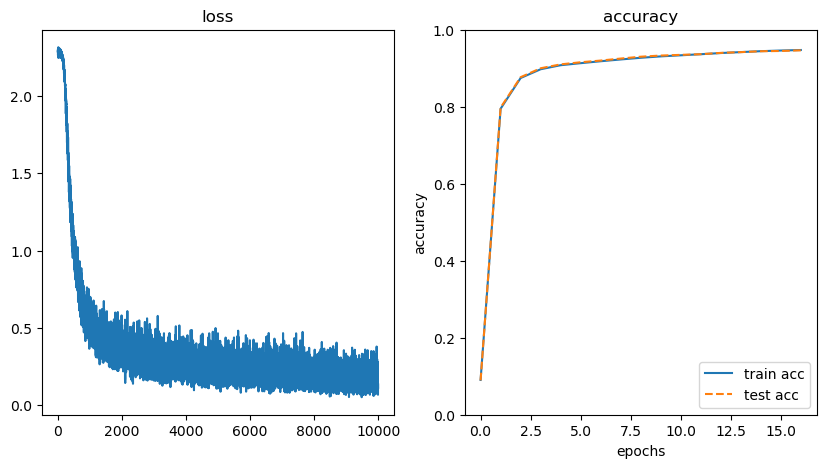

In [54]:
# 그래프 그리기
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(train_loss_list)
plt.title("loss")
plt.subplot(122)
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("accuracy")
plt.show()

## 이번 장에서 배운 내용
* 기계학습에서 사용하는 데이터셋은 훈련 데이터와 시험 데이터로 나눠 사용한다.
* 훈련 데이터로 학습한 모델의 범용 능력을 시험 데이터로 평가한다.
* 신경망 학습은 손실 함수를 지표로, 손실 함수의 값이 작아지는 방향으로 가중치 매개변수를 갱신한다.
* 가중치 매개변수를 갱신할 때는 가중치 매개변수의 기울기를 이용하고, 기울어진 방향으로 가중치의 값을 갱신하는 작업을 반복한다.
* 아주 작은 값을 주었을 때의 차분으로 미분하는 것을 수치 미분이라고 한다.
* 수치 미분을 이용해 가중치 매개변수의 기울기를 구할 수 있다.
* 수치 미분을 이용한 계산에는 시간이 걸리지만, 그 구현은 간단하다. 한편, 다음 장에서 구현하는 (다소 복잡한) 오차역전파법은 기울기를 고속으로 구할 수 있다.